In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [12]:
torch.cuda.is_available()

False

In [ ]:
data = pd.read_csv('squares_filtered.csv')

In [7]:
data["label"] = data.apply(lambda row: "north" if row["max_lat"] > 31 else "south", axis=1)

In [10]:
data = data.loc[:, ["education", "scenic", "sports", "commercial", "financial", "transport", "label"]]

In [109]:
class GridDataset(Dataset):
    def __init__(self, df, columns=["education", "scenic", "sports", "commercial", "financial", "transport"]):
        self.data = df.loc[:, columns].values.astype(np.float32)
        self.data /= self.data.max()
        self.labels = df.loc[:, "label"].values

        label_mapping = {label: i for i, label in enumerate(np.unique(self.labels))}
        self.labels = np.array([label_mapping[label] for label in self.labels])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [168]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, labels):
        label = (labels[None, :] == labels[:, None]).float().flatten()
        
        # Compute Euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output[None,:,:], output[:,None,:]).flatten()
        # Loss for positive pairs
        positive_loss = label * torch.pow(euclidean_distance, 2)
        # Loss for negative pairs
        negative_loss = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        # Combine losses
        loss = torch.mean(positive_loss + negative_loss)
        return loss


In [173]:
train_test_split = 0.8
train_idx = np.random.choice(data.index, int(len(data) * train_test_split), replace=False)
train_data = GridDataset(data.loc[train_idx])
test_data = GridDataset(data.drop(train_idx))

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [174]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.network(x)


In [175]:
def generate_pairs(data, labels):
    pairs = []
    pair_labels = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            if labels[i] == labels[j]:
                pairs.append((data[i], data[j]))
                pair_labels.append(1)  # Positive pair
            else:
                pairs.append((data[i], data[j]))
                pair_labels.append(0)  # Negative pair
    return pairs, pair_labels


In [177]:
# Initialize model, loss, and optimizer
embedding_dim = 16
model = Encoder(input_dim=6, embedding_dim=embedding_dim)
loss_fn = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 1000
pbar = tqdm(total=n_epochs)
try:
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for batch_data, batch_labels in train_loader:

            output = model(batch_data)

            # Compute loss
            loss = loss_fn(output, batch_labels)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        pbar.update(1)
        pbar.set_description(f"Loss: {round(epoch_loss / len(train_loader),3)}")
finally:
    pbar.close()

Loss: 0.271: 100%|██████████| 1000/1000 [00:24<00:00, 40.16it/s]


In [178]:
embeddings = torch.tensor([])
for batch, labels in test_loader:
    embeddings = torch.cat((embeddings, model(batch)))

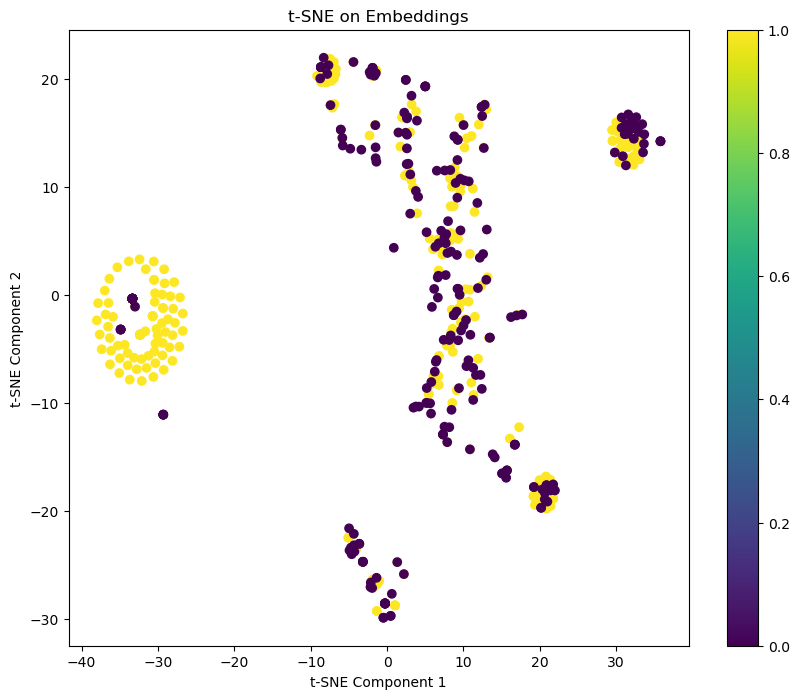

In [179]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=test_loader.dataset.labels)
plt.colorbar()
plt.title('t-SNE on Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()